### Colab Stuff

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/ThesisFinal")

### Agent analysis

In [ ]:
from rl_env.environment import runAgent, RandomWalkEnv
from rl_env.agents import QAgent, LeakyActor3
from rl_env.agent_analysis import plot_q_session, analyze_q_session, plot_leaky_session, analyze_leaky_agent

env = RandomWalkEnv()
q_agent = QAgent()

choices, rewards, qs, reward_probs = runAgent(env=env, agent=q_agent, n_trials=400)
plot_q_session(choices=choices,
               rewards=rewards,
               timeseries=qs.transpose(),
               timeseries_colours=["#ff8a59", "#b491ff"],
               timeseries_labels=["Q-left", "Q-right"],
               timeseries_name="Q-values",
               save="figures/q_agent_example_session.png")
analyze_q_session(choices=choices,
                  rewards=rewards,
                  qs=qs,
                  save="figures/q_agent_analysis.png")

leaky_agent = LeakyActor3()
choices, rewards, qs, reward_probs = runAgent(env=env, agent=leaky_agent, n_trials=400)
plot_leaky_session(choices=choices,
                   rewards=rewards,
                   v=qs[:,1],
                   theta=qs[:,0],
                   save="figures/leakyactor_agent_example_session.png")

analyze_leaky_agent(LeakyActor3(), save="figures/leakyactor_agent_analysis.png")

## Pomdp plots

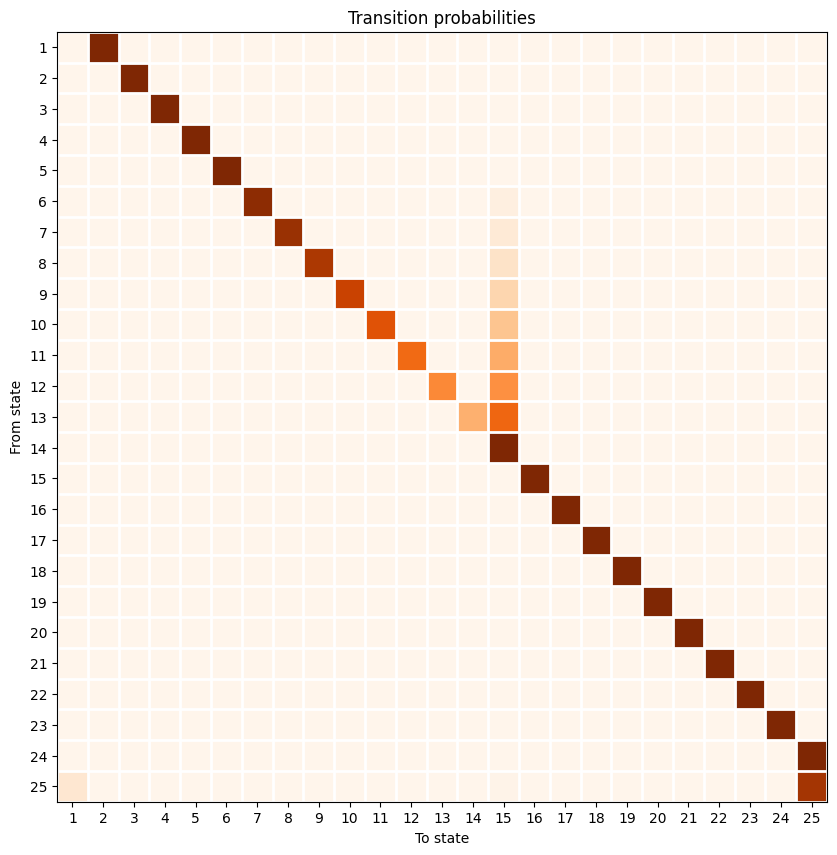

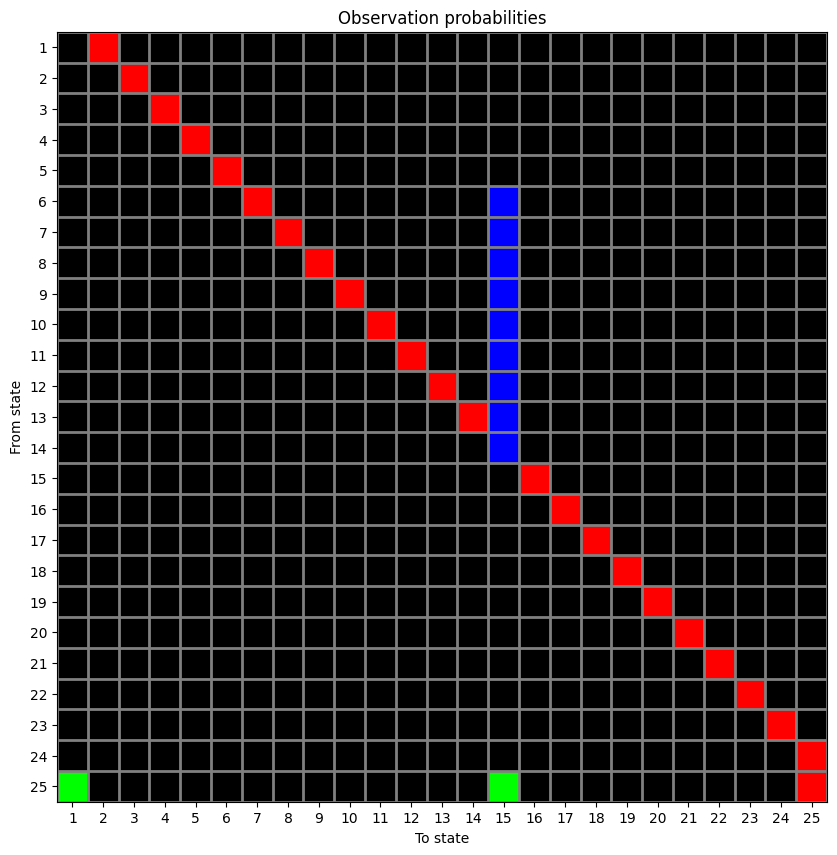

In [1]:
from belief_pomdp import _get_transistion_observation_probs, plot_pomdp_tables

T, O = _get_transistion_observation_probs(0.1, 1/8, 11)
plot_pomdp_tables(T, O)